In [20]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
from itertools import combinations, permutations
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import networkx as nx

%matplotlib inline

In [73]:
def turn_to_url(season):
    return 'http://survivor.wikia.com/wiki/Survivor:_' + season.replace(' ','_')

def process(string):
    stripped = string.strip()
    return re.sub('[0-9]+', '', stripped)

def extract_voting_table_as_df(link):
    """
    Extract the voting history table as a pandas data frame.
    Input: link - url for the season page in Survivor wiki
    Output: dd - pandas dataframe of the voting history table
    """
    cara = requests.get(link)
    soup = BeautifulSoup(cara.content, 'lxml')

    # use select() bec 2 css classes
    voting_table = soup.select('table.wikitable.article-table')[-1]
    # obtain the table cells of the voters (the leftmost column)
    names = voting_table.find_all('td', style = 'text-align: left;')
    names.extend(voting_table.find_all('td', style = 'text-align: left; white-space: nowrap;'))

    # obtain the names of the voters as strings
    contestants = []
    for voter in names:
        contestants.append(process(voter.text))
    #print(len(contestants))

    no_vote = ['Quit', 'Evacuated']
    # we will convert this list into a pandas df
    season_list = []

    for voter in names:
        voter_dict = {'Name' : process(voter.text)}
        inc = 0
        for voted in voter.find_next_siblings():
            if process(voted.text) in ['Jury Vote','']:
                break
            # some cell span more than one column
            # compensate for this by adding more '—'
            if voted.has_attr('colspan'):
                numcol = int(voted['colspan'])
                for i in range(numcol):  
                    voter_dict[inc] = '—'
                    inc += 1
                continue
            
            if (process(voted.text) in contestants) or (process(voted.text) == '—') or (process(voted.text) in no_vote):
                voter_dict[inc] = process(voted.text)
            inc += 1
        season_list.append(voter_dict)
    #print(season_list)
    
    # convert the list into a pd data frame and set as index the voters
    dd = pd.DataFrame(season_list).set_index('Name')
    # rearrange the columns of the data frame in increasing order
    dd = dd[sorted(dd.columns)]
    
    # remove columns which represent no voting: evacuated or quit
    del_cols = []
    for i in dd.columns:
        if ('Evacuated' in dd[i].values) or ('Quit' in dd[i].values):
            del_cols.append(i)
    dd=dd.drop(del_cols,axis=1)
    
    return dd

seasons = ['Borneo', 'The Australian Outback', 'Africa', 'Marquesas', 'Thailand', 'The Amazon', 
           'Pearl Islands', 'All-Stars', 'Vanuatu', 'Palau', 'Guatemala', 'Panama', 
           'Cook Islands', 'Fiji', 'China', 'Micronesia', 'Gabon', 'Tocantins', 'Samoa', 
           'Heroes vs. Villains', 'Nicaragua', 'Redemption Island', 'South Pacific',
           'One World', 'Philippines', 'Caramoan', 'Cagayan', 'San Juan del Sur',
           'Worlds Apart', 'Cambodia', 'Kaôh Rōng', 'Millennials vs. Gen X',
           'Game Changers']

extract_voting_table_as_df(turn_to_url(seasons[-8]))

In [102]:
def return_affiliation_df(dd):
    """
        Returns an affiliation index data frame per voting round
        input: dd - data frame of voting history
        output: affiliation_dict_list - data frame of affiliation index per voting round
    """
    flatten = lambda l: [item for sublist in l for item in sublist]
    contestants = dd.index
    pairs = list(combinations(contestants,2))
    affiliation_dict_list = []
    
    # iterate over voting rounds
    for col_index in dd.columns:
        # get the clusters who voted for particular people
        voting_dict = dd.groupby(col_index).groups
        # if not a name, remove from the voting dict
        for i in ['','—']:
            if i in voting_dict.keys():
                voting_dict.pop(i)
        # everyone who voted in tribal council
        in_tribal = set(flatten(voting_dict.values()))
        # get all the people who received votes at tribal
        candidates = voting_dict.keys()
        candidates = [name for name in candidates if name in contestants]
                
        # get the vote counts of the people who received votes
        vote_counts = []
        for voted in candidates:
            vote_counts.append(len(voting_dict[voted]))
 
        affiliation_dict = defaultdict(int)
        # initialize all pairs of people in tribal to have affiliation value of 0
        for i in in_tribal:
            for j in in_tribal:
                if (i,j) in pairs:
                    affiliation_dict[(i,j)] = 0
        # in the case of tiebreakers, or when only 2 people are at risk, set affiliation value
        # of a pair of contestants to 1 if they voted together
        if 'None' in voting_dict.keys() or len(candidates) < 3:
            for voted in candidates:
                for i in voting_dict[voted]:
                    for j in voting_dict[voted]:
                        if (i,j) in pairs:
                            affiliation_dict[(i,j)] = 1 
            affiliation_dict_list.append(affiliation_dict)
            continue
        # in the case of split votes:
        else:
            # there are usually 3 names thrown out during split votes:
            # the 2 targets of the majority affiliation, and the target of the
            # people in the minority.

            # get who the contestants at risk voted for
            candidates_voted_for = dict()
            for voted in candidates:
                for other in candidates:
                    if voted in voting_dict[other]:
                        candidates_voted_for[voted]=other
            print(col_index,candidates_voted_for)
                        
            # cross contains all possible 3 pairs of the contestants at risk
            cross = list(combinations(candidates,3))
            # cluster_i represents the contestants who voted for contestant i
            for (voted1, voted2, voted3) in cross:
                cluster1 = voting_dict[voted1]
                cluster2 = voting_dict[voted2]
                cluster3 = voting_dict[voted3]

                # set affiliation value of a pair of contestants to 1 if the they
                # belong to the same cluster
                for i in cluster1:
                    for j in cluster1:
                        if (i,j) in pairs:
                            affiliation_dict[(i,j)] = 1

                for i in cluster2:
                    for j in cluster2:
                        if (i,j) in pairs:
                            affiliation_dict[(i,j)] = 1

                for i in cluster3:
                    for j in cluster3:
                        if (i,j) in pairs:
                            affiliation_dict[(i,j)] = 1

                # target_i is the vote of the ith contestant at risk
                target1 = candidates_voted_for[voted1]
                target2 = candidates_voted_for[voted2]
                target3 = candidates_voted_for[voted3]

                voteds = [voted1,voted2,voted3]
                clusters = [cluster1, cluster2, cluster3]
                targets = [target1, target2, target3]
                index_pairs = combinations([0,1,2],2)
                for (ix1, ix2) in index_pairs:
                    for cluster in clusters:
                        # check if more than 1 person votes for contestant ix1 and more than
                        # 1 person votes for contestant ix2, then they are candidates for the
                        # split vote.
                        if (len(clusters[ix1]) > 1) and (len(clusters[ix2]) > 1):
                            # check if the targets of contenstant ix1 and ix2 are the same
                            # if yes, then the people who voted for ix1 and ix2 did a split
                            # vote and are in an affiliation
                            if (targets[ix1] in cluster) and (targets[ix2] in cluster):
                                everyone = flatten([clusters[ix1],clusters[ix2]])
                                for i in everyone:
                                    for j in everyone:
                                        if (i,j) in pairs:
                                            # assign affiliation = 1 to all who voted for 
                                            # ix1 and ix2
                                            affiliation_dict[(i,j)] = 1
                                # since ix1 and ix2 voted together, they are in a
                                # minority affiliation
                                if (voted[ix1], voted[ix2]) in pairs:
                                    affiliation_dict[(voted[ix1], voted[ix2])] = 1
                                elif (voted[ix2], voted[ix1]) in pairs:
                                    affiliation_dict[(voted[ix2], voted[ix1])] = 1
            affiliation_dict_list.append(affiliation_dict)
    return pd.DataFrame(affiliation_dict_list).T

In [23]:
def calculate_alliance_index(series):
    """
        Calculate the alliance index which is defined as:
            alliance((i,j),t) = (1/t_{i,j})*sum_0^t(affiliation((i,j))
        where (i,j) is a contestant pair and t is the voting round and t_{i,j} is the
        number of times (i,j) appeared at voting round together
        
        alliance((i,j),t) is basically the percentage of the time that
        i and j agreed on who to vote out
        
        alliance(i,j) = alliance((i,j),T), where T is the last elimination voting round,
        can be used to summarize the relationship of (i,j) for the season
    
        note that alliance(i,j) does not consider the number of tribal councils
        that i and j  experienced together. to take this into account, we can filter 
        the pairings to find significant relationships (for example, consider only pairs 
        who experienced 5 voting rounds together)
        
        input : series - pandas series
        output : alliance index series
    """
    series = series.dropna()
    out = []
    for i in range(len(series)):
        out.append(series[:i+1].mean())
    return pd.Series(out, index=series.index)

In [24]:
def return_alliance_df_with_filter(dd, k):
    """
        Return data frame of alliance index for every voting round
        input:
            dd - data frame of voting table
            k - filter for the number of voting rounds together
    """
    adf = return_affiliation_df(dd)
    return adf[adf.count(axis=1)>k].apply(calculate_alliance_index,axis=1).fillna(method='ffill',axis=1)

In [25]:
def find_str(tup,string):
    return (tup[0] == string) or (tup[1] == string)

def simplify(tup, selected):
    if selected == tup[0]:
        return tup[1]
    else:
        return tup[0]

def plot_contestant_top_with_filter(dd, selected, m=5, k=5):
    """
        Plot top m contestants in terms of alliance_index with selected
        input:
            dd - data frame of voting table
            selected - contestant that you are focusing on
            m - top contestants to consider
            k - filter for number of voting rounds
    """
    filtered = return_alliance_df_with_filter(dd, k)
    with_selected = filtered[[find_str(i,selected) for i in filtered.index]].sort_values(len(filtered.columns)-1,ascending=False)
    top_m = with_selected.ix[:m]
    top_m = top_m.reset_index()
    top_m['index'] = top_m['index'].apply(simplify,args=(selected,))
    top_m = top_m.set_index('index')
    top_m.T.plot(style='o-', ms=8).legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("{}'s top {} relationships (>{} voting rounds together)".format(selected, m, k))
    plt.ylabel('Alliance index $A(t)$')
    plt.xlabel('Voting round $t$')
    plt.xticks(list(top_m.columns))
    plt.yticks(np.arange(0,1.1,.1))
    plt.xlim(-1,len(top_m.columns))
    plt.ylim(-0.1,1.1)
    
def return_df_contestant_top_with_filter(dd, selected, m, k=1):
    """
        return df of the plot above
    """
    filtered = return_alliance_df_with_filter(dd, k)
    with_selected = filtered[[find_str(i,selected) for i in filtered.index]].sort_values(len(filtered.columns)-1,ascending=False)
    top_m = with_selected.ix[:m]
    return top_m

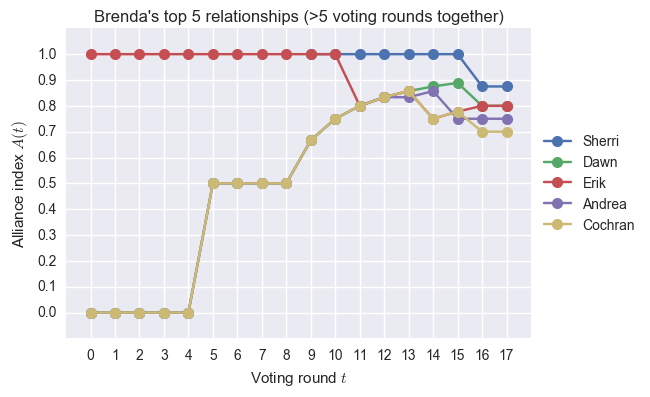

In [26]:
caramoan = extract_voting_table_as_df(turn_to_url('Caramoan'))
plot_contestant_top_with_filter(caramoan, "Brenda", 5, k=5)

In [43]:
def return_top_m_relationships(dd, m, k):
    """
        return the top m relationships of the season (measured via final alliance index)
        filtered by k times together in a voting round
    """
    adf = return_alliance_df_with_filter(dd, k)
    # sort values in decreasing alliance index
    adf = adf.sort_values(len(adf.columns)-1, ascending=False).ix[:m,len(adf.columns)-1]
    # remove if 0 already
    return adf[adf!=0]

In [41]:
top50 = return_top_m_relationships(caramoan, 50, 5)
top50

(Dawn, Sherri)        1.000000
(Cochran, Phillip)    1.000000
(Cochran, Sherri)     0.888889
(Dawn, Phillip)       0.875000
(Sherri, Brenda)      0.875000
(Eddie, Reynold)      0.875000
(Dawn, Andrea)        0.875000
(Cochran, Dawn)       0.857143
(Dawn, Corinne)       0.833333
(Sherri, Andrea)      0.833333
(Erik, Brenda)        0.800000
(Dawn, Brenda)        0.800000
(Brenda, Andrea)      0.750000
(Cochran, Andrea)     0.750000
(Cochran, Brenda)     0.700000
(Cochran, Erik)       0.700000
(Michael, Julia)      0.666667
(Cochran, Corinne)    0.666667
(Sherri, Michael)     0.666667
(Phillip, Corinne)    0.666667
(Sherri, Erik)        0.625000
(Dawn, Erik)          0.600000
(Reynold, Michael)    0.500000
(Erik, Andrea)        0.500000
(Erik, Malcolm)       0.333333
(Andrea, Malcolm)     0.333333
(Dawn, Malcolm)       0.333333
(Cochran, Malcolm)    0.333333
(Eddie, Erik)         0.250000
(Eddie, Andrea)       0.166667
(Sherri, Eddie)       0.166667
(Brenda, Malcolm)     0.166667
(Eddie, 

In [29]:
def plot_season_contestant_top_with_filter(season_name,selected, m=5, k=5):
    url = turn_to_url(season_name)
    dd = extract_voting_table_as_df(url)
    filtered = return_alliance_df_with_filter(dd, k)
    with_selected = filtered[[find_str(i,selected) for i in filtered.index]].sort_values(len(filtered.columns)-1,ascending=False)
    top_m = with_selected.ix[:m]
    top_m = top_m.reset_index()
    top_m['index'] = top_m['index'].apply(simplify,args=(selected,))
    top_m = top_m.set_index('index')
    sns.set_style("darkgrid")
    top_m.T.plot(style='o-', ms=8).legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("{}'s top {} relationships (>{} voting rounds together)".format(selected, m, k))
    plt.ylabel('Alliance index $A(t)$')
    plt.xlabel('Voting round $t$')
    plt.xticks(list(top_m.columns))
    plt.yticks(np.arange(0,1.1,.1))
    plt.xlim(-1,len(top_m.columns))
    plt.ylim(-0.1,1.1)

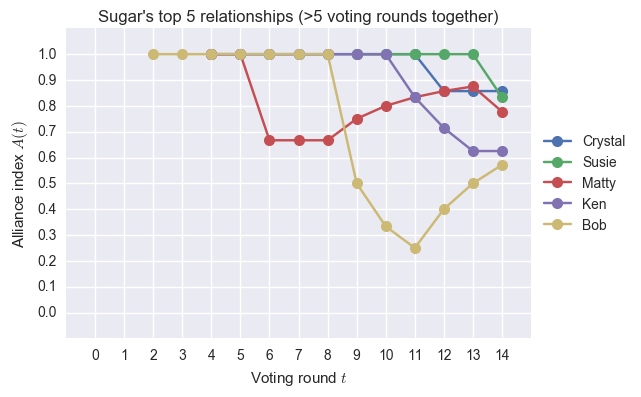

In [30]:
plot_season_contestant_top_with_filter('Gabon','Sugar', m=5, k=5)

In [31]:
def plot_network(season_name,m=50,k=3):
    url = turn_to_url(season_name)
    dd = extract_voting_table_as_df(url)
    top_m = return_top_m_relationships(dd, m, k)
    #print(top_m)
    plt.close()
    sns.set_style("white")
    plt.figure(figsize=(7,7))
    G=nx.Graph()

    with_edge = []
    for i in dd.index:
        for tup in top_m.index:
            if i in tup:
                with_edge.append(i)
                break
    G.add_nodes_from(with_edge)

    goldenrod=(218./255, 165./255, 32./255)
    gray=(0.9,0.9,0.9)
    #print(return_alliance_df_with_filter(dd, k))
    for i in range(len(top_m.index)):
        G.add_edge(top_m.index[i][0], top_m.index[i][1], weight=top_m.values[i])
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color = goldenrod,node_size=800)
    nx.draw_networkx_labels(G,pos)
    weights = [5*G[u][v]['weight'] for u,v in G.edges()]
    nx.draw_networkx_edges(G,pos,width=weights,alpha= 0.7,edge_color = 'green')
    plt.title('{} Castaway Relationships. Top {}, Filter >{}'.format(season_name, m, k))
    plt.tick_params(
        axis='both',        
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        left='off',         # ticks along the top edge are off
        labelbottom='off',
        labelleft='off') # labels along the bottom edge are off
    plt.savefig('{}_network_top_{}_filter_{}.png'.format(season_name,m,k))

In [103]:
seasons = ['Borneo', 'The Australian Outback', 'Africa', 'Marquesas', 'Thailand', 'The Amazon', 
           'Pearl Islands', 'All-Stars', 'Vanuatu', 'Palau', 'Guatemala', 'Panama', 
           'Cook Islands', 'Fiji', 'China', 'Micronesia', 'Gabon', 'Tocantins', 'Samoa', 
           'Heroes vs. Villains', 'Nicaragua', 'Redemption Island', 'South Pacific',
           'One World', 'Philippines', 'Caramoan', 'Cagayan', 'San Juan del Sur',
           'Worlds Apart', 'Cambodia', 'Kaôh Rōng', 'Millennials vs. Gen X',
           'Game Changers']

Borneo
0 {'Stacey': 'Rudy', 'Rudy': 'Sonja', 'Sonja': 'Rudy'}
3 {'Jenna': 'Ramona', 'Ramona': 'Colleen', 'Colleen': 'Ramona'}
4 {'Susan': 'Dirk', 'Rudy': 'Dirk', 'Dirk': 'Susan'}
6 {'Jenna': 'Gervase', 'Gervase': 'Susan', 'Gretchen': 'Rudy', 'Colleen': 'Richard', 'Susan': 'Gretchen', 'Rudy': 'Gretchen', 'Richard': 'Gretchen'}
8 {'Jenna': 'Richard', 'Richard': 'Jenna', 'Sean': 'Jenna'}
The Australian Outback
2 {'Jerri': 'Maralyn', 'Maralyn': 'Jerri', 'Mitchell': 'Maralyn'}
13 {'Amber': 'Nick', 'Keith': 'Nick', 'Nick': 'Keith'}
Africa
Marquesas
0 {'Sarah': 'Peter', 'Peter': 'Patricia', 'Patricia': 'Peter'}
6 {'Zoe': 'Rob', 'John': 'Rob', 'Rob': 'John'}
Thailand
0 {'Ghandia': 'John', 'John': 'Ghandia', 'Clay': 'John'}
9 {'Penny': 'Jake', 'Jan': 'Penny', 'Jake': 'Jan'}
The Amazon
0 {'Roger': 'Ryan', 'Daniel': 'Roger', 'Ryan': 'Roger'}
1 {'Jenna': 'Janet', 'Janet': 'Jeanne', 'Jeanne': 'Janet', 'Christy': 'Jenna'}
3 {'Christy': 'Joanna', 'Joanna': 'Shawna', 'Shawna': 'Christy'}
Pearl Islands

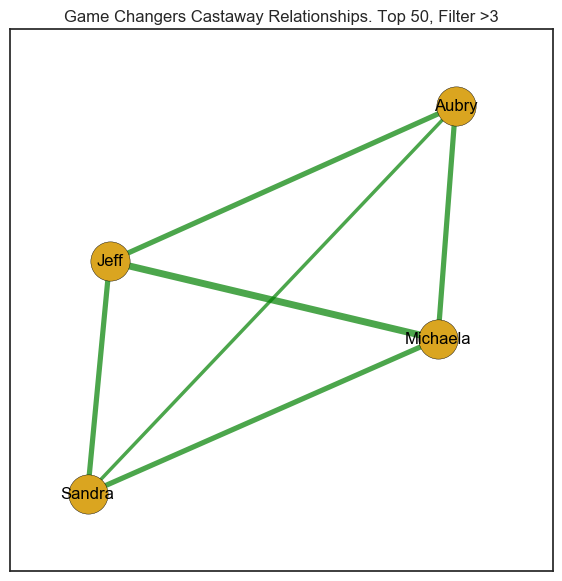

In [104]:
for season in seasons:
    print(season)
    plot_network(season)